Successfully loaded and prepared 100 articles.

Vectorizing text data with TF-IDF...
Data split into 80 training samples and 20 testing samples.

Training the XGBoost Classifier...
Training complete.

--- Evaluating XGBoost Model Performance ---

     XGBoost Model Evaluation
Final Test Set Accuracy: 0.6500

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.70      0.64      0.67        11

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20


--- Generating Visualizations ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:15:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


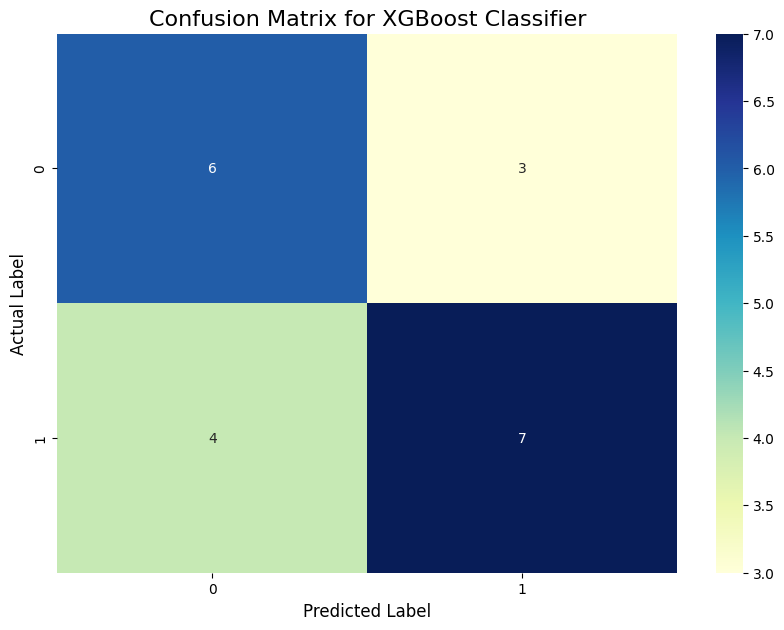

/tmp/ipython-input-395630016.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features, y=top_features.index, palette='mako')


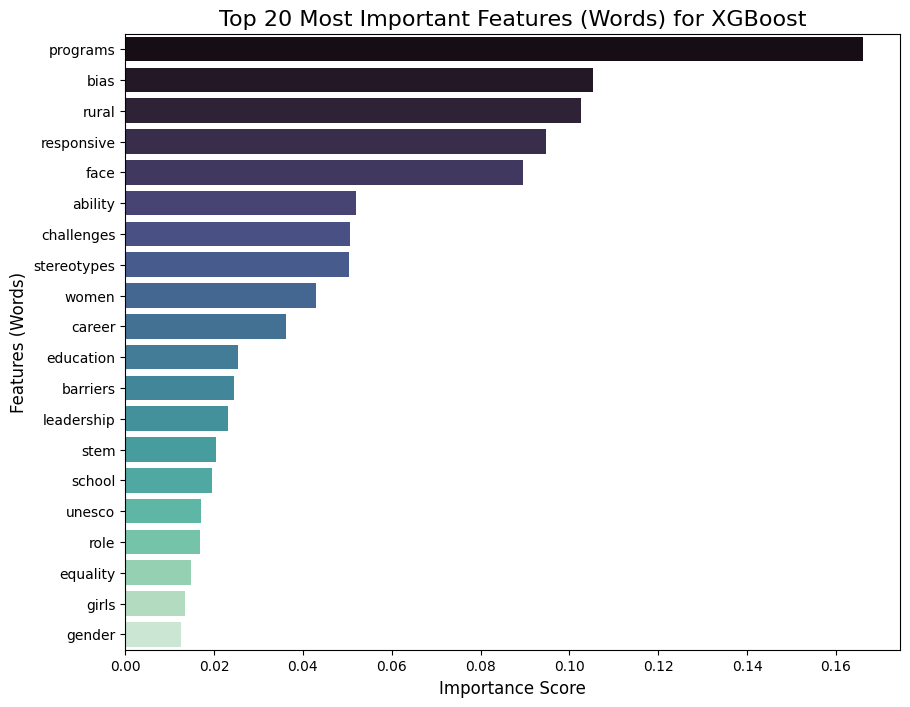

In [ ]:
# Step 1: Install XGBoost and import libraries
# XGBoost is not a default library, so we need to install it first.
!pip install xgboost

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 2: Load and Prepare the Data ---
try:
    df = pd.read_csv('Dataset100.csv')
    # Create a single text column for classification
    df['full_text'] = df['title'] + " " + df['summary']
    df.dropna(subset=['full_text', 'label'], inplace=True)
    print(f"Successfully loaded and prepared {len(df)} articles.")
except FileNotFoundError:
    print("Error: Dataset100.csv not found. Please ensure the file is uploaded.")
    exit()

# Define Features (X) and Target (y)
X = df['full_text']
y = df['label']

# --- Step 3: Vectorize Text with TF-IDF ---
print("\nVectorizing text data with TF-IDF...")
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# --- Step 4: Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split into {len(y_train)} training samples and {len(y_test)} testing samples.")

# --- Step 5: Train the XGBoost Classifier ---
print("\nTraining the XGBoost Classifier...")

# Initialize the XGBoost Classifier
# use_label_encoder=False is recommended to avoid a deprecation warning
xgb_model = XGBClassifier(
    objective='binary:logistic', # For binary classification
    n_estimators=100,            # Number of boosting rounds
    learning_rate=0.1,           # Step size shrinkage
    max_depth=5,                 # Maximum depth of a tree
    use_label_encoder=False,
    eval_metric='logloss',       # Evaluation metric for the validation set
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)
print("Training complete.")

# --- Step 6: Evaluate the Model ---
print("\n--- Evaluating XGBoost Model Performance ---")
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate and display the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\n" + "="*50)
print("     XGBoost Model Evaluation")
print("="*50)
print(f"Final Test Set Accuracy: {accuracy:.4f}")
print("="*50)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# --- Step 7: Visualize the Results ---
print("\n--- Generating Visualizations ---")

# --- GRAPH 1: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(y) # Get unique class names

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for XGBoost Classifier', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# --- GRAPH 2: Feature Importance ---
feature_importances = pd.Series(xgb_model.feature_importances_, index=tfidf.get_feature_names_out())
top_features = feature_importances.nlargest(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_features, y=top_features.index, palette='mako')
plt.title('Top 20 Most Important Features (Words) for XGBoost', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features (Words)', fontsize=12)
plt.show()